In [ ]:
SEED = 61

import numpy as np
import tensorflow as tf
import random as python_random
import os

def reset_seeds():
    np.random.seed(SEED) 
    python_random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    
import os
import re
import gc
import tensorflow_addons as tfa
import h5py
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk import tokenize

from sklearn import preprocessing
from sklearn.decomposition import PCA

from keras import backend as K
from keras import initializers,regularizers,constraints
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, Input, Embedding, Flatten, Dense, Dropout, BatchNormalization, Activation #, merge
from keras.layers import TimeDistributed, LSTM, GRU, Bidirectional, Convolution1D, MaxPooling1D, MaxPooling2D
from keras.layers.core import RepeatVector #, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import cross_val_score

from tensorflow.python.keras.layers import Layer, InputSpec, Lambda

from transformers import BertTokenizer, BertForMaskedLM, BertModel

# from tensorflow.keras import Model
# from attention import Attention_input1, Attention_input2
# from keras.optimizers import SGD, RMSprop, Adagrad

In [ ]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')
    
    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

def loadz(path):
    data = np.load(path)['arr_0']
    return data

In [ ]:
def load_labels(path):
    data = read_hdf5(path)

    for x in data:
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]
        
    return labels, text_labels, image_labels

# Load data

In [ ]:
mvsa_single_bert = loadz('../input/mvsa-features/bert-base/mvsa-single-bert-base.npz')
mvsa_multiple_bert = loadz('../input/mvsa-features/bert-base/mvsa-multiple-bert-base.npz')
mvsa_single_vgg16 = loadz('../input/mvsa-features/vgg16/mvsa-single-vgg16.npz')
mvsa_multiple_vgg16 = loadz('../input/mvsa-features/vgg16/mvsa-multiple-vgg16.npz')

In [ ]:
mvsa_single_multimodal_labels, mvsa_single_text_labels, mvsa_single_image_labels = load_labels('../input/mvsa-features/labels/mvsa-single-labels.hdf5')
mvsa_multiple_multimodal_labels, mvsa_multiple_text_labels, mvsa_multiple_image_labels = load_labels('../input/mvsa-features/labels/mvsa-multiple-labels.hdf5')

# Prepare data

In [ ]:
# e.g. validation_split=0.1 -----> 8:1:1 ratio of train, val, test
def split_data(data, validation_split):
    num_val = int(validation_split * data.shape[0])
    data_train = data[:-(num_val*2)]
    data_val = data[-(num_val*2):-(num_val)]
    data_test = data[-num_val:]
    return data_train, data_val, data_test

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(mvsa_single_multimodal_labels)
tokenized_labels = le.transform(mvsa_single_multimodal_labels)
mvsa_single_labels = to_categorical(np.asarray(tokenized_labels))

NUM_CLASSES = len(le.classes_) # = 3

In [ ]:
VALIDATION_SPLIT = 0.1

text_train, text_val, text_test = split_data(mvsa_single_bert, VALIDATION_SPLIT)
image_train, image_val, image_test = split_data(mvsa_single_vgg16, VALIDATION_SPLIT)
label_train,label_val, label_test = split_data(mvsa_single_labels, VALIDATION_SPLIT)

print('Number of train data:', text_train.shape[0])
print('Number of validation data:', text_val.shape[0])
print('Number of test data:', text_test.shape[0])

In [ ]:
print('Text BERT (last layer CLS) vector shape:', text_train.shape[1:])
print('Image VGG-16 vector shape:', image_train.shape[1:])

# My Intermediate Fusion

In [ ]:
reset_seeds()
DIM_LSTM = 128#16
EPOCHS = 100
BATCH_SIZE = 1000
DROPOUT_RATE = 0.2

In [ ]:
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [133]:
def create_model_IF(summary=False):
    f1_score = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='micro')
#     f1_score = tfa.metrics.FBetaScore(num_classes= NUM_CLASSES, average="macro", name='f1_score')
    image_input = Input(shape=image_train.shape[1:])

    text_input = Input(shape=(1, text_train.shape[1]))
    text_lstm = Bidirectional(LSTM(DIM_LSTM)) (text_input)
#     text_lstm = Dropout(DROPOUT_RATE) (text_lstm)
    
    text_image_concat = tf.keras.layers.Concatenate(axis=1)([text_lstm, image_input])
    concat_self_attention = tf.keras.layers.Attention() ([text_image_concat, text_image_concat])
#     concat_self_attention = Dropout(DROPOUT_RATE) (concat_self_attention)
    
    concat_softmax = Dense(NUM_CLASSES, activation='softmax') (concat_self_attention)
    
    model = Model([text_input, image_input], concat_softmax)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score]) # f1 #tf.keras.metrics.AUC()
    
    if summary == True:
        print(model.summary())
    return model

In [134]:
model_IF = create_model_IF(summary=True)

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 1, 768)]     0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 256)          918528      input_36[0][0]                   
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 4096)]       0                                            
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 4352)         0           bidirectional_1[0][0]            
                                                                 input_35[0][0]            

In [135]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10)
checkpoint_IF = ModelCheckpoint('./model_checkpoint/{}.h5'.format('intermediate-fusion'), save_best_only=True, verbose=1)

In [136]:
history_IF = model_IF.fit([text_train.reshape((-1, 1, text_train.shape[1])), image_train], label_train, 
               epochs=EPOCHS, batch_size=BATCH_SIZE,
               validation_data=([text_val.reshape((-1, 1, text_val.shape[1])), image_val], label_val), 
               callbacks=[checkpoint_IF])

Epoch 1/100
4/4 [==============================] - 4s 305ms/step - loss: 1.4781 - accuracy: 0.4239 - f1_score: 0.4239 - val_loss: 1.2501 - val_accuracy: 0.3457 - val_f1_score: 0.3457

Epoch 00001: val_loss improved from inf to 1.25011, saving model to ./model_checkpoint/intermediate-fusion.h5
Epoch 2/100
4/4 [==============================] - 0s 26ms/step - loss: 1.3355 - accuracy: 0.4247 - f1_score: 0.4247 - val_loss: 1.0716 - val_accuracy: 0.5893 - val_f1_score: 0.5893

Epoch 00002: val_loss improved from 1.25011 to 1.07159, saving model to ./model_checkpoint/intermediate-fusion.h5
Epoch 3/100
4/4 [==============================] - 0s 31ms/step - loss: 1.1551 - accuracy: 0.4896 - f1_score: 0.4896 - val_loss: 1.3663 - val_accuracy: 0.1439 - val_f1_score: 0.1439

Epoch 00003: val_loss did not improve from 1.07159
Epoch 4/100
4/4 [==============================] - 0s 27ms/step - loss: 1.0648 - accuracy: 0.4745 - f1_score: 0.4745 - val_loss: 1.0232 - val_accuracy: 0.5893 - val_f1_score: 

In [ ]:
# num_folds = 5
# kfold = KFold(n_splits=num_folds, shuffle=False)
# ID_Inp = text_train.reshape((-1, 1, text_train.shape[1]))
# ID_Out = image_train
# Inputs = [ID_Inp,ID_Out]
# # inputs = [text_train.reshape((-1, 1, text_train.shape[1])), image_train]

# for IDs_Train, IDs_Test in kfold.split(ID_Inp, ID_Out):
#     Fold_Train_Input1, Fold_Train_Input2 = Input1[IDs_Train], Input2[IDs_Train]
#     Fold_Train_OutPut = Output[IDs_Train]

#     Fold_Test_Input1, Fold_Test_Input2 = Input1[IDs_Test], Input2[IDs_Test]
#     Fold_Test_OutPut = Output[IDs_Test]

# Evaluation

In [137]:
# hidden 16 dropout 0.1 after text lstm CPU
model_IF = load_model('./model_checkpoint/{}.h5'.format('intermediate-fusion'))#, custom_objects={'f1': f1})
loss_IF, acc_IF, f1_IF = model_IF.evaluate([text_test.reshape((-1, 1, text_train.shape[1])), image_test], label_test)
print('\nIntermediate fusion model evaluation')
print('Loss:', loss_IF)
print('Accuracy:', acc_IF)
print('F1-score:', f1_IF)

14/14 [==============================] - 1s 4ms/step - loss: 0.7989 - accuracy: 0.6172 - f1_score: 0.6172

Intermediate fusion model evaluation
Loss: 0.7989054322242737
Accuracy: 0.6171693801879883
F1-score: 0.6171693801879883


In [ ]:
# hidden 16 dropout 0.1 after text lstm CPU
model_IF = load_model('./model_checkpoint/{}.h5'.format('intermediate-fusion'), custom_objects={'f1': f1})
loss_IF, acc_IF, f1_IF = model_IF.evaluate([text_test.reshape((-1, 1, text_train.shape[1])), image_test], label_test)
print('\nIntermediate fusion model evaluation')
print('Loss:', loss_IF)
print('Accuracy:', acc_IF)
print('F1-score:', f1_IF)

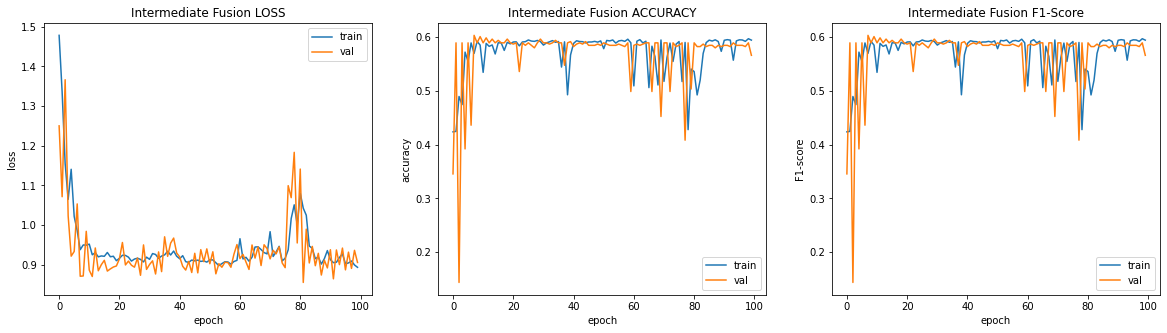

In [138]:
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(1, 3, 1)
plt.plot(history_IF.history['loss'])
plt.plot(history_IF.history['val_loss'])
plt.title('Intermediate Fusion LOSS')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')

fig.add_subplot(1, 3, 2)
plt.plot(history_IF.history['accuracy'])
plt.plot(history_IF.history['val_accuracy'])
plt.title('Intermediate Fusion ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')

fig.add_subplot(1, 3, 3)
plt.plot(history_IF.history['f1_score'])
plt.plot(history_IF.history['val_f1_score'])
plt.title('Intermediate Fusion F1-Score')
plt.ylabel('F1-score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')

plt.show()

# Drafts

In [ ]:
# def old_read_hdf5(path):
#     read_file = h5py.File(path, 'r')
    
#     feature_names = list(read_file.keys())
#     loaded_data = []
    
#     for name in feature_names:
#         dataset = read_file[name][:]
#         if dataset.dtype == np.dtype('object'):
#             dataset = np.array([x.decode('UTF-8') for x in dataset])            
#         loaded_data.append(dataset)

#     return loaded_data, feature_names #text_features, image_features_16, image_features_19, multimodal_labels, text_labels, image_labels

# def merge_mvsa(path_single, path_multiple):
#     mvsa_concat = []
    
#     mvsa_single, feature_names = read_hdf5(path_single)
#     mvsa_multiple, _ = read_hdf5(path_multiple)
#     print('Number of data in MVSA-Single:', mvsa_single[0].shape[0])
#     print('Number of data in MVSA-Multiple:', mvsa_multiple[0].shape[0])
#     print('Data containing features:', feature_names)

#     for i in range(len(mvsa_single)):
#         concat = np.concatenate((mvsa_single[i], mvsa_multiple[i]), axis=0)
#         mvsa_concat.append((feature_names[i], concat))
#     print('Total mumber of both data:', mvsa_concat[0][1].shape[0])

#     return mvsa_concat

# mvsa_data = merge_mvsa('../input/mvsa-features/mvsa-single-bert-vgg.hdf5', '../input/mvsa-features/mvsa-multiple-bert-vgg.hdf5')

# # When get loadded data with its dataset name, the keys got sorted alphabetically (features list above), CAREFUL when use with other files
# for x in mvsa_data:
#     if x[0] == 'bert-base':
#         mvsa_bert = x[1]
#     if x[0] == 'vgg-16':
#         mvsa_vgg16 = x[1]
#     if x[0] == 'vgg-19':
#         mvsa_vgg19 = x[1]
#     if x[0] == 'multimodal-labels':
#         mvsa_multimodal_labels = x[1]
#     if x[0] == 'text-labels':
#         mvsa_text_labels = x[1]
#     if x[0] == 'image-labels':
#         mvsa_image_labels = x[1]
        
# del x, mvsa_data
# gc.collect()

In [ ]:
# mvsa_single_bert, mvsa_single_vgg16, \
# mvsa_single_vgg19, mvsa_single_multimodal_labels, \
# mvsa_single_text_labels, mvsa_single_image_labels = load_data('../input/mvsa-features/mvsa-single-bert-vgg.hdf5')

# mvsa_multiple_bert, mvsa_multiple_vgg16, \
# mvsa_multiple_vgg19, mvsa_multiple_multimodal_labels, \
# mvsa_multiple_text_labels, mvsa_multiple_image_labels = load_data('../input/mvsa-features/mvsa-multiple-bert-vgg.hdf5')

# mvsa_bert0 = np.concatenate((mvsa_single_bert, mvsa_multiple_bert), axis=0)
# mvsa_vgg160 = np.concatenate((mvsa_single_vgg16, mvsa_multiple_vgg16), axis=0)
# mvsa_vgg190 = np.concatenate((mvsa_single_vgg19, mvsa_multiple_vgg19), axis=0)
# mvsa_multimodal_labels0 = np.concatenate((mvsa_single_multimodal_labels, mvsa_multiple_multimodal_labels), axis=0)
# mvsa_text_labels0 = np.concatenate((mvsa_single_text_labels, mvsa_multiple_text_labels), axis=0)
# mvsa_image_labels0 = np.concatenate((mvsa_single_image_labels, mvsa_multiple_image_labels), axis=0)

In [ ]:
# def load_data(path):
#     read_file = h5py.File(path, 'r')
    
#     feature_names = list(read_file.keys())
#     loaded_data = []
    
#     for name in feature_names:
#         dataset = read_file[name][:]
        
#         if dataset.dtype == np.dtype('object'):
#             dataset = np.array([x.decode('UTF-8') for x in dataset])
            
#         loaded_data.append(dataset)
    
    
# #     text_features = read_file['bert-base'][:]
# #     image_features_16 = read_file['vgg-16'][:]
# #     image_features_19 = read_file['vgg-19'][:]
    
# #     multimodal_labels = read_file['multimodal-labels'][:]
# #     text_labels = read_file['text-labels'][:]
# #     image_labels = read_file['image-labels'][:]
    
# #     multimodal_labels = np.array([x.decode('UTF-8') for x in multimodal_labels]) # decode to utf-8 because hd5py save text object as binary string b'' thingy
# #     text_labels = np.array([x.decode('UTF-8') for x in text_labels]) # decode to utf-8 because hd5py save text object as binary string b'' thingy
# #     image_labels = np.array([x.decode('UTF-8') for x in image_labels]) # decode to utf-8 because hd5py save text object as binary string b'' thingy
    
#     return loaded_data, feature_names #text_features, image_features_16, image_features_19, multimodal_labels, text_labels, image_labels